In [1]:
%env TF_ENABLE_ONEDNN_OPTS=0

env: TF_ENABLE_ONEDNN_OPTS=0


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session

In [3]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [4]:
print("We're using TF", tf.__version__)
print("We are using Keras", keras.__version__)

We're using TF 2.9.1
We are using Keras 2.9.0


In [5]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)

In [6]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

2022-07-23 16:20:56.197263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-23 16:20:56.278106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 16:20:56.387518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 16:20:56.387892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

'/device:GPU:0'

In [7]:
#GPU count and name
!nvidia-smi -L

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
GPU 0: NVIDIA GeForce RTX 3080 Ti (UUID: GPU-3640a850-99c1-dc54-6fa7-580525d9e5af)


In [1]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sat Jul 23 17:51:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 30%   47C    P5    45W / 350W |  11516MiB / 12288MiB |     42%      Default |
|                               |                      |                  N/A |
+-------------------------------+-------------------

# MNIST

In [9]:
# скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

In [10]:
# что за данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


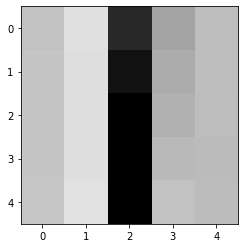

Пример картинки:


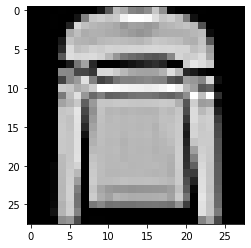

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [11]:
# нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

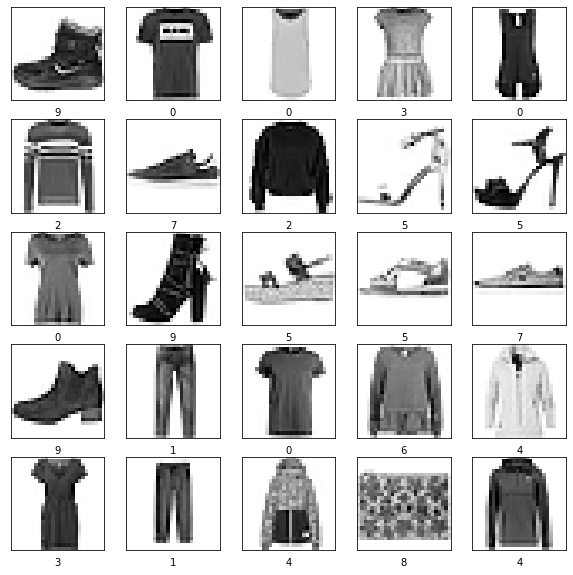

In [12]:
# Посмотрим побольше примеров
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

# Data

In [13]:
# вытянем картинку в вектор размера 28*28=784 и будем использовать это как фичи!

x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [14]:
# центрируем и нормируем, так сети будет проще учиться
x_train_float = x_train_flat.astype(float) / 255 - 0.5
x_val_float = x_val_flat.astype(float) / 255 - 0.5

# по сути, это действия аналогичны нормализации через StandardScaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_train_flat = scaler.fit_transform(x_train_flat)
# x_val_flat = scaler.transform(x_val_flat)

# Но попробуйте пропустить нормирование и посмотрите что будет ;)
# x_train_float = x_train_flat.astype(float)
# x_val_float = x_val_flat.astype(float)

In [15]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0 3 0]


# Собираем модель

Самостоятельно постойте Multi layer Perceptron (MLP) классификатор (по аналогии с практическеской частью, но на новых данных)

In [16]:
clear_session()

In [17]:
x_train_float.shape[1]

784

In [18]:
# Тут ваш код Архитектуры сети
# не забудьте 10 выходов с активацией softmax на выходном слое!

# Архитектура сети
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(x_train_float.shape[1],))) # первый скрытый слой
model.add(Dense(128, activation='relu',)) # второй скрытый слой
model.add(Dense(10, activation='softmax',)) # выходной слой

2022-07-23 16:21:32.155369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 16:21:32.155533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 16:21:32.155613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 16:21:32.155844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 16:21:32.155934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [21]:
%%time
history = model.fit(
                    x_train_float, 
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Epoch 1/10
155/938 [===>..........................] - ETA: 0s - loss: 0.6755 - accuracy: 0.7603

2022-07-23 16:22:00.332160: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


938/938 [==============================] - 3s 1ms/step - loss: 0.4794 - accuracy: 0.8268 - val_loss: 0.4338 - val_accuracy: 0.8451
Epoch 2/10
938/938 [==============================] - 1s 1ms/step - loss: 0.3643 - accuracy: 0.8661 - val_loss: 0.4150 - val_accuracy: 0.8499
Epoch 3/10
938/938 [==============================] - 1s 1ms/step - loss: 0.3273 - accuracy: 0.8788 - val_loss: 0.3697 - val_accuracy: 0.8682
Epoch 4/10
938/938 [==============================] - 1s 1ms/step - loss: 0.3001 - accuracy: 0.8889 - val_loss: 0.3638 - val_accuracy: 0.8704
Epoch 5/10
938/938 [==============================] - 1s 1ms/step - loss: 0.2843 - accuracy: 0.8945 - val_loss: 0.3539 - val_accuracy: 0.8757
Epoch 6/10
938/938 [==============================] - 1s 1ms/step - loss: 0.2652 - accuracy: 0.9008 - val_loss: 0.3482 - val_accuracy: 0.8790
Epoch 7/10
938/938 [==============================] - 1s 1ms/step - loss: 0.2500 - accuracy: 0.9054 - val_loss: 0.3539 - val_accuracy: 0.8769
Epoch 8/10
938/93

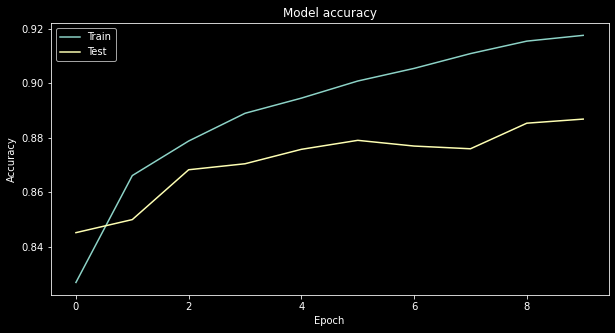

In [22]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

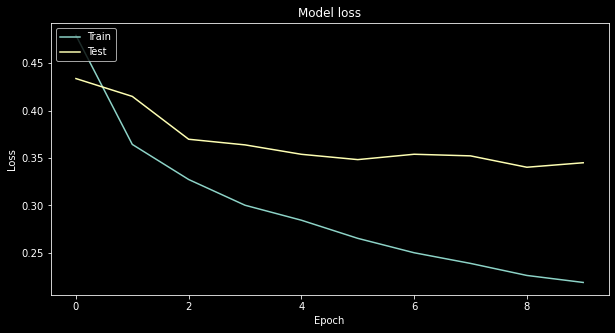

In [23]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
predicts = np.argmax(model.predict(x_val_float), axis = 1)
print('Test Accuracy: ', accuracy_score(y_val, predicts))

313/313 [==============================] - 0s 513us/step
Test Accuracy:  0.8868


Что вам необходимо сделать:
1. Обучите сеть без скрытых слоев. (Построить аналог обычной линейной модели) **Какое accuracy на валидации получили?**
2. Обучите сеть с двумя скрытыми слоями по 128 нейронов в каждом. **Какое accuracy на валидации получили?**
3. **Сколько параметров в последней сети?**

Удачи!

In [25]:
#from keras.layers import Input

In [26]:
clear_session()

In [27]:
model = Sequential()
#model.add(Dense(128, activation='relu', input_shape=(x_train_float.shape[1],))) # первый скрытый слой
#model.add(Dense(128, activation='relu',)) # второй скрытый слой
model.add(Dense(10, activation='softmax', input_shape=(x_train_float.shape[1],))) # выходной слой

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [30]:
history = model.fit(
                    x_train_float, 
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Epoch 1/10
938/938 [==============================] - 1s 961us/step - loss: 0.6211 - accuracy: 0.7893 - val_loss: 0.5202 - val_accuracy: 0.8159
Epoch 2/10
938/938 [==============================] - 1s 890us/step - loss: 0.4725 - accuracy: 0.8371 - val_loss: 0.4832 - val_accuracy: 0.8304
Epoch 3/10
938/938 [==============================] - 1s 939us/step - loss: 0.4446 - accuracy: 0.8463 - val_loss: 0.4736 - val_accuracy: 0.8357
Epoch 4/10
938/938 [==============================] - 1s 862us/step - loss: 0.4329 - accuracy: 0.8502 - val_loss: 0.4629 - val_accuracy: 0.8387
Epoch 5/10
938/938 [==============================] - 1s 874us/step - loss: 0.4247 - accuracy: 0.8535 - val_loss: 0.4586 - val_accuracy: 0.8368
Epoch 6/10
938/938 [==============================] - 1s 934us/step - loss: 0.4180 - accuracy: 0.8557 - val_loss: 0.4531 - val_accuracy: 0.8372
Epoch 7/10
938/938 [==============================] - 1s 872us/step - loss: 0.4116 - accuracy: 0.8576 - val_loss: 0.4484 - val_accuracy:

In [32]:
predicts = np.argmax(model.predict(x_val_float), axis = 1)
print('Test Accuracy: ', accuracy_score(y_val, predicts))

313/313 [==============================] - 0s 452us/step
Test Accuracy:  0.8379
